<a href="https://www.kaggle.com/code/taliyameyswara/accent-detection-done?scriptVersionId=210101915" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/speech-accent-archive/reading-passage.txt
/kaggle/input/speech-accent-archive/speakers_all.csv
/kaggle/input/speech-accent-archive/recordings/recordings/spanish47.mp3
/kaggle/input/speech-accent-archive/recordings/recordings/english220.mp3
/kaggle/input/speech-accent-archive/recordings/recordings/arabic64.mp3
/kaggle/input/speech-accent-archive/recordings/recordings/russian7.mp3
/kaggle/input/speech-accent-archive/recordings/recordings/dutch36.mp3
/kaggle/input/speech-accent-archive/recordings/recordings/english518.mp3
/kaggle/input/speech-accent-archive/recordings/recordings/bengali5.mp3
/kaggle/input/speech-accent-archive/recordings/recordings/english52.mp3
/kaggle/input/speech-accent-archive/recordings/recordings/arabic11.mp3
/kaggle/input/speech-accent-archive/recordings/recordings/farsi11.mp3
/kaggle/input/speech-accent-archive/recordings/recordings/khmer7.mp3
/kaggle/input/speech-accent-archive/recordings/recordings/french41.mp3
/kaggle/input/speech-accent-archive/r

In [5]:
import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import re

In [6]:
# Path to the dataset
dir = '/kaggle/input/speech-accent-archive/recordings/recordings'
audio_list = os.listdir(dir)

In [7]:
# Create DataFrame
df = pd.DataFrame()
df['speech'] = audio_list

# Extract labels (accents) from filenames
df['labels'] = [re.sub(r'\d+\.mp3$', '', audio) for audio in audio_list]

df.head()

,speech,labels
0,spanish47.mp3,spanish
1,english220.mp3,english
2,arabic64.mp3,arabic
3,russian7.mp3,russian
4,dutch36.mp3,dutch


In [13]:
# Define the class names you want to keep
class_names = [
    "arabic", "dutch", "english", "french", "german", 
    "italian", "korean", "mandarin", "polish", "portuguese", 
    "russian", "spanish", "turkish"
]

# Filter to keep only the selected class labels
filtered_df = df[df['labels'].isin(class_names)]

filtered_df.head()

filtered_df.value_counts()

speech          labels 
arabic1.mp3     arabic     1
italian7.mp3    italian    1
korean23.mp3    korean     1
korean22.mp3    korean     1
korean21.mp3    korean     1
                          ..
english356.mp3  english    1
english355.mp3  english    1
english354.mp3  english    1
english353.mp3  english    1
turkish9.mp3    turkish    1
Name: count, Length: 1306, dtype: int64

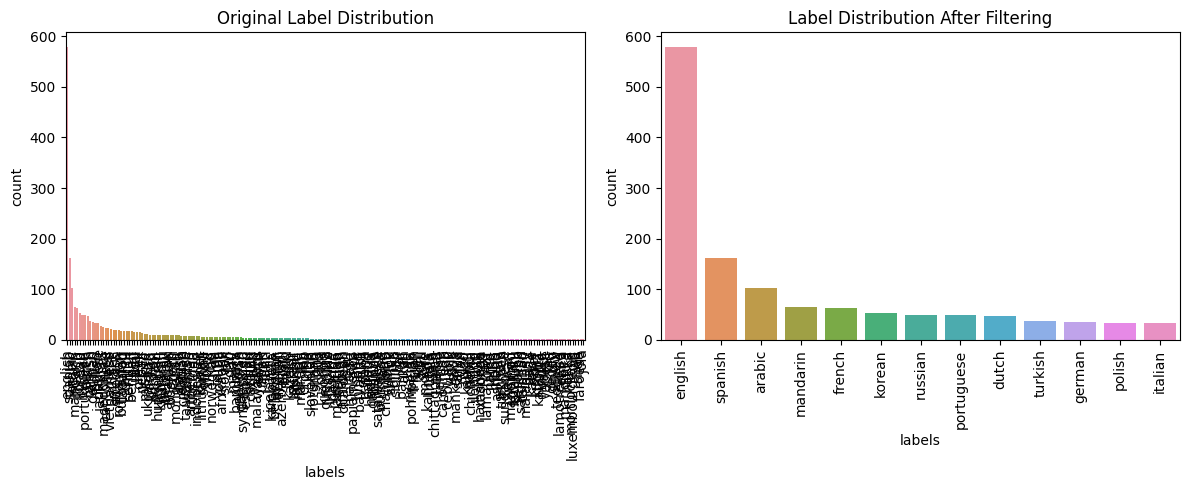

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up a 1-row, 2-column subplot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Visualize the original label distribution in the first subplot
sns.countplot(data=df, x='labels', order=df['labels'].value_counts().index, ax=ax[0])
ax[0].set_title('Original Label Distribution')
ax[0].tick_params(axis='x', rotation=90)

# Visualize the label distribution after filtering in the second subplot
sns.countplot(data=filtered_df, x='labels', order=filtered_df['labels'].value_counts().index, ax=ax[1])
ax[1].set_title('Label Distribution After Filtering')
ax[1].tick_params(axis='x', rotation=90)

# Show the plots
plt.tight_layout()
plt.show()

In [19]:
# Feature extraction function
def extract_mfcc(file_path, n_mfcc=13):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

In [20]:
# Extract features for all audio files
features = []
for file in filtered_df['speech']:
    file_path = os.path.join(dir, file)
    mfcc = extract_mfcc(file_path)
    features.append(mfcc)

In [23]:
# Convert features to a numpy array
X = np.array(features)
y = filtered_df['labels'].values

# Print the shape of X and y to see the data structure
print("Shape of X:", X.shape)  # Shape of the feature matrix
print("Shape of y:", y.shape)  # Shape of the labels array

Shape of X: (1306, 13)
Shape of y: (1306,)


In [25]:
# Encode the labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


In [28]:
# Apply RandomOverSampler to balance the classes
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y_encoded)

# Convert the resampled encoded labels back to the original labels
y_resampled_labels = label_encoder.inverse_transform(y_resampled)

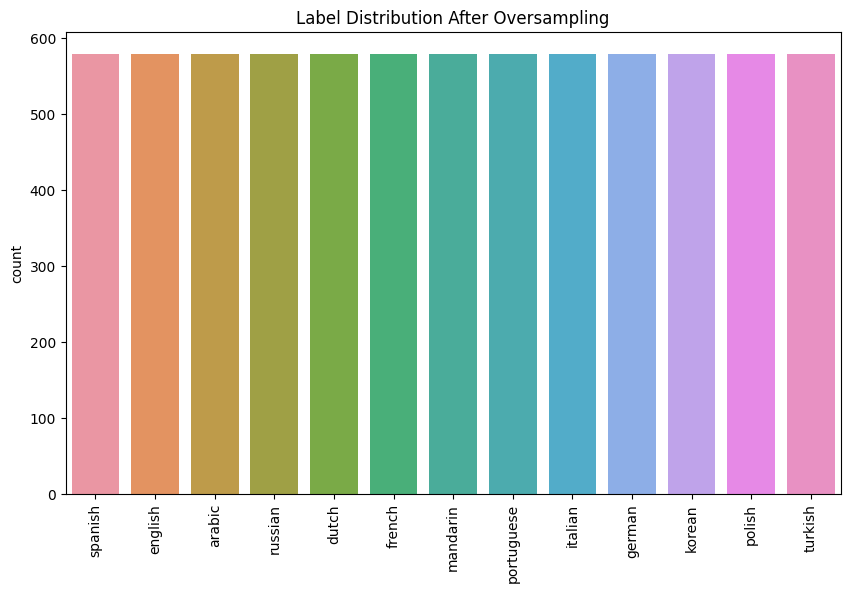

In [30]:
# Visualize the label distribution after oversampling
plt.figure(figsize=(10, 6))
sns.countplot(x=pd.Series(y_resampled_labels))
plt.title('Label Distribution After Oversampling')
plt.xticks(rotation=90)
plt.show()

In [47]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_labels, test_size=0.2, random_state=42)

# Reshape data for CNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Visualize the shape of training and testing data
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Print the shapes of y_train and y_test
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Training data shape: (6021, 13, 1)
Testing data shape: (1506, 13, 1)
y_train shape: (6021,)
y_test shape: (1506,)


In [51]:
from tensorflow.keras.utils import to_categorical

# Ensure the labels are encoded as integers (this should already be done)
# Using the previously encoded labels
y_train_encoded = label_encoder.transform(y_train)  # Use LabelEncoder's transform method
y_test_encoded = label_encoder.transform(y_test)

# Now, one-hot encode the labels
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)

# Build the CNN model
# Hyperparameter tuning & Model improvements
from tensorflow.keras.layers import BatchNormalization

# Build the CNN model
model = Sequential()

# First convolutional layer with normalization
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())  # Added batch normalization
model.add(MaxPooling1D(pool_size=2))

# Second convolutional layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())  # Added batch normalization
model.add(MaxPooling1D(pool_size=2))

# Flatten the output of convolutional layers
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Compile the model with a lower learning rate for more stable convergence
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model with early stopping to avoid overfitting
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_26 (Conv1D)              │ (None, 11, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 11, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 3, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,917 (171.55 KB)

 Trainable params: 43,533 (170.05 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1377 - loss: 2.6646 - val_accuracy: 0.1985 - val_loss: 2.3833
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2489 - loss: 2.2868 - val_accuracy: 0.3413 - val_loss: 2.1004
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3209 - loss: 2.0697 - val_accuracy: 0.4376 - val_loss: 1.8140
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3763 - loss: 1.8882 - val_accuracy: 0.4907 - val_loss: 1.6222
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4351 - loss: 1.7357 - val_accuracy: 0.5777 - val_loss: 1.4610
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4855 - loss: 1.5690 - val_accuracy: 0.6242 - val_loss: 1.3059
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5141 - loss: 1.5037 - val_accuracy: 0.6740 - val_loss: 1.1512
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5634 - loss: 1.3637 - val_accuracy: 0.

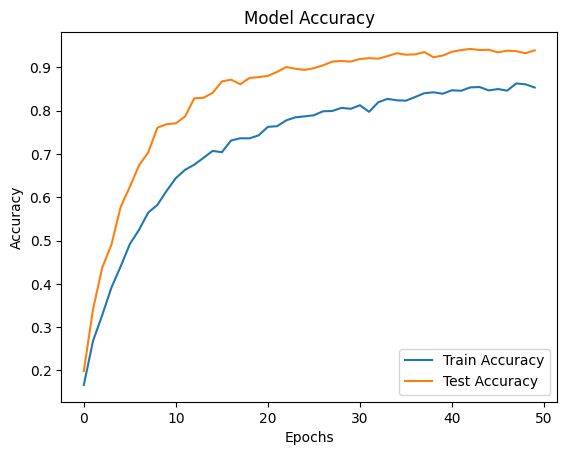

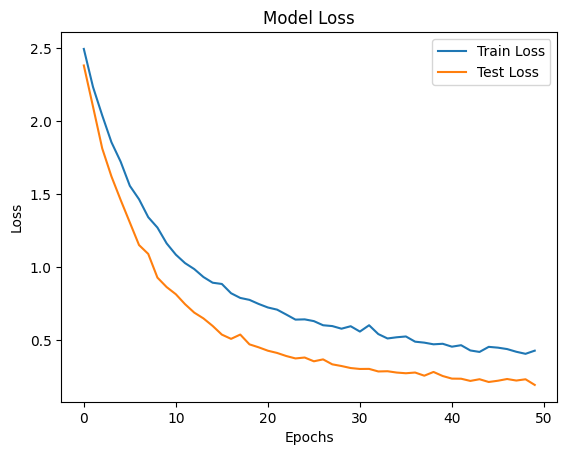

In [52]:

# Visualize the training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualize the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9440 - loss: 0.1839
Test Loss: 0.1915837973356247
Test Accuracy: 0.9395750164985657


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predicted Accuracy: 0.9395750332005313


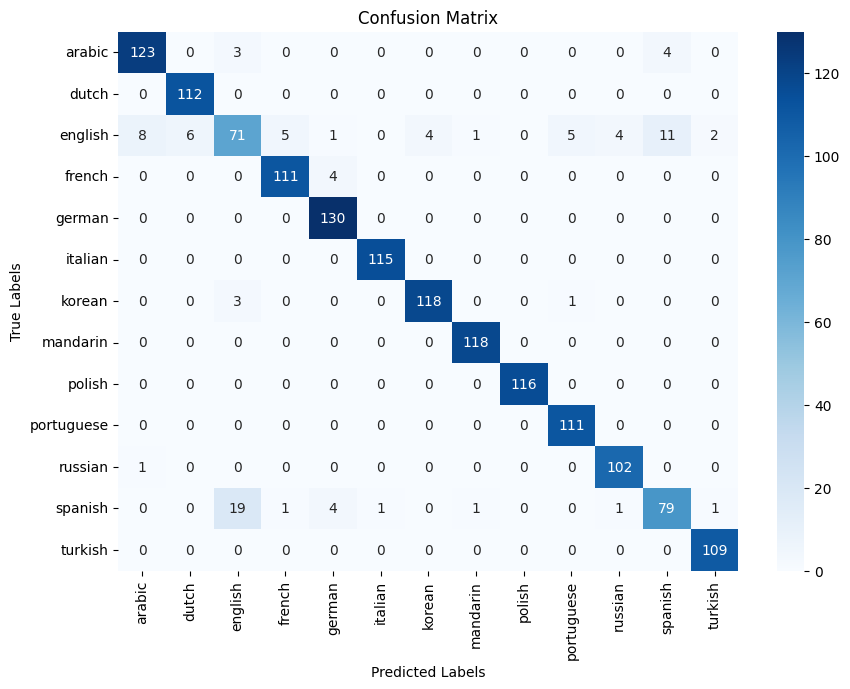

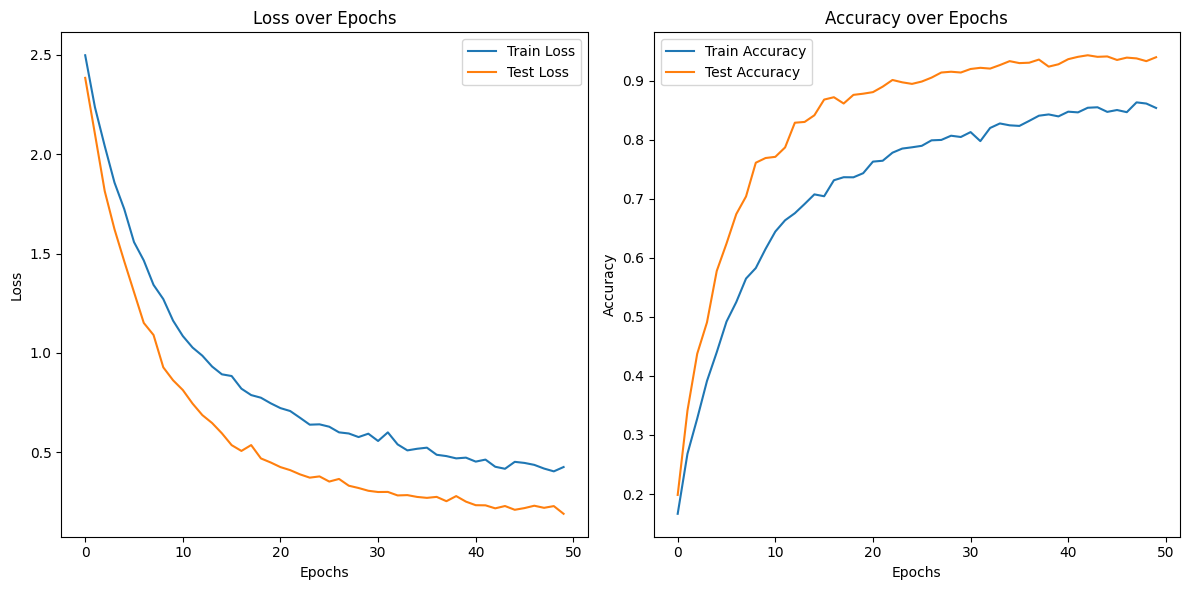

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted class for the sample: portuguese


In [57]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Menggunakan np.argmax untuk mendapatkan kelas dengan probabilitas tertinggi
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Ambil kelas dengan probabilitas tertinggi

# Menggunakan label_encoder untuk mengonversi y_test kembali ke label integer jika diperlukan
# Misalnya y_test sudah ter-encode, maka kita bisa langsung menggunakan y_test
# Pastikan y_test adalah integer encoded labels, bukan one-hot
# Misalnya, jika y_test sudah berupa integer (hasil transformasi dengan LabelEncoder), kita bisa menggunakan langsung.

y_test_int = label_encoder.transform(y_test)  # Mengubah y_test menjadi integer encoded jika diperlukan

# Menghitung akurasi prediksi
accuracy_pred = accuracy_score(y_test_int, y_pred)
print(f"Predicted Accuracy: {accuracy_pred}")

# Confusion Matrix
cm = confusion_matrix(y_test_int, y_pred)

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plot Training and Testing Loss & Accuracy
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Contoh prediksi untuk sample dari X_test
sample_index = 0  # Ambil indeks sample pertama
sample = X_test[sample_index].reshape(1, X_test.shape[1], 1)  # Reshape untuk input model

# Prediksi label untuk sample
predicted_label = model.predict(sample)
predicted_class = label_encoder.inverse_transform([np.argmax(predicted_label)])

print(f"Predicted class for the sample: {predicted_class[0]}")

In [58]:
model.save('cnn.h5')

In [60]:
import librosa
import numpy as np
from tensorflow.keras.models import load_model

# Fungsi untuk mengekstrak MFCC dari file audio
def extract_mfcc(file_path, n_mfcc=13):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)  # Rata-rata untuk setiap koefisien MFCC
    return mfcc_mean

# Path ke file audio yang ingin diprediksi
example_file = '/kaggle/input/speech-accent-archive/recordings/recordings/afrikaans1.mp3'

# Ekstraksi fitur MFCC dari file audio
mfcc_features = extract_mfcc(example_file)

# Reshape untuk menyesuaikan dengan input model (1, n_features, 1)
mfcc_features_reshaped = mfcc_features.reshape(1, mfcc_features.shape[0], 1)

# Memuat model yang sudah dilatih (misalnya model yang telah disimpan sebelumnya)
# Jika model sudah dilatih sebelumnya, muat model dengan cara ini:
model = load_model('cnn.h5')  # Gantilah dengan path model Anda jika sudah disimpan

# Lakukan prediksi
predicted_prob = model.predict(mfcc_features_reshaped)
predicted_class = np.argmax(predicted_prob, axis=1)

# Mengonversi hasil prediksi kembali ke label asli menggunakan LabelEncoder
predicted_label = label_encoder.inverse_transform(predicted_class)

print(f"Predicted label for the audio file: {predicted_label[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Predicted label for the audio file: arabic


In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Hyperparameter tuning & Model improvements
model = Sequential()

# First convolutional layer with normalization
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())  # Added batch normalization
model.add(MaxPooling1D(pool_size=2))

# Second convolutional layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())  # Added batch normalization
model.add(MaxPooling1D(pool_size=2))

# Global Average Pooling layer to reduce overfitting and make the model more robust
model.add(GlobalAveragePooling1D())

# Fully connected layer
model.add(Dense(128, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Optimizer with adjusted learning rate (lower rate for stability)
optimizer = Adam(learning_rate=0.0005)  # Adjusted learning rate

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Learning rate scheduler to reduce learning rate as training progresses
def lr_schedule(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        lr = lr * 0.7  # Reduce learning rate by 30% every 10 epochs
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping and learning rate scheduler
history = model.fit(X_train, y_train_encoded, epochs=100, batch_size=32, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping, lr_scheduler])


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_31 (Conv1D)              │ (None, 11, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 11, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 3, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,917 (171.55 KB)

 Trainable params: 43,533 (170.05 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1315 - loss: 2.8347 - val_accuracy: 0.2523 - val_loss: 2.3560 - learning_rate: 5.0000e-04
Epoch 2/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2433 - loss: 2.2855 - val_accuracy: 0.3466 - val_loss: 2.1138 - learning_rate: 5.0000e-04
Epoch 3/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3080 - loss: 2.1248 - val_accuracy: 0.4382 - val_loss: 1.9171 - learning_rate: 5.0000e-04
Epoch 4/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3568 - loss: 1.9717 - val_accuracy: 0.4841 - val_loss: 1.7680 - learning_rate: 5.0000e-04
Epoch 5/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4014 - loss: 1.8573 - val_accuracy: 0.5133 - val_loss: 1.6491 - learning_rate: 5.0000e-04
Epoch 6/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4505 - loss: 1.7350 - val_accuracy: 0.5691 - val_loss: 1.5177 - learning_rate: 5.0000e-04
Epoch 7/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc

In [63]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9435 - loss: 0.1956
Test Loss: 0.20964230597019196
Test Accuracy: 0.9422310590744019


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Predicted Accuracy: 0.9422310756972112


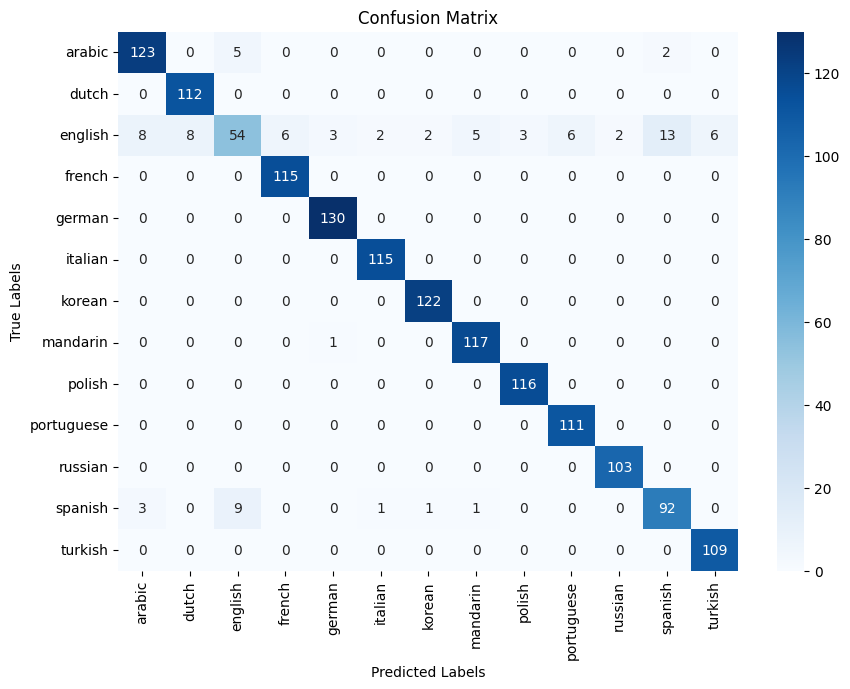

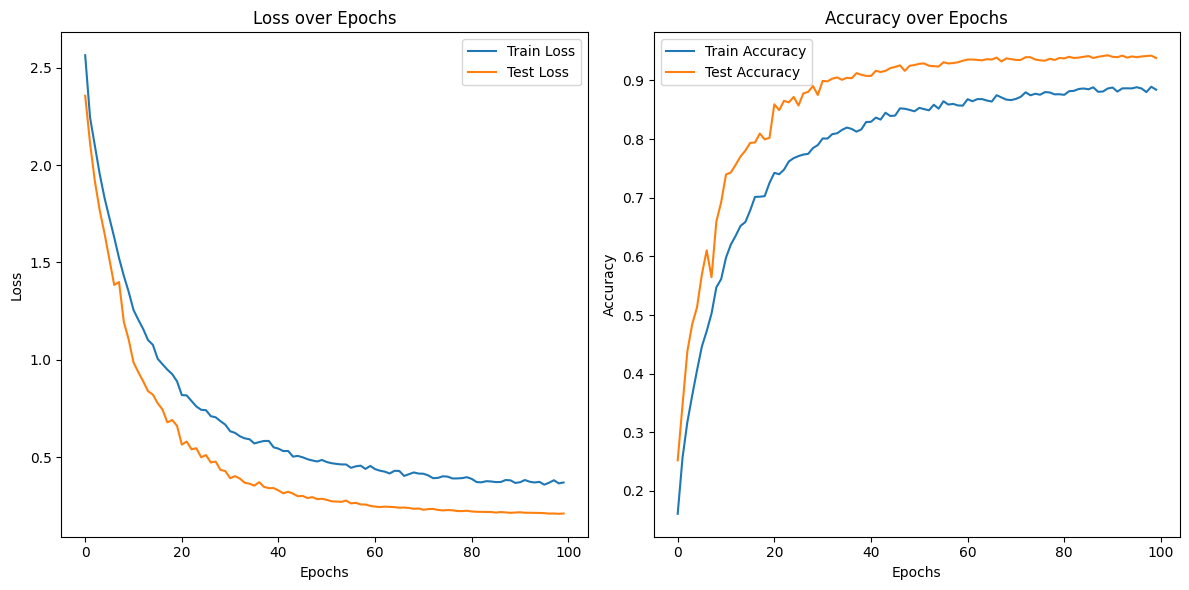

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class for the sample: portuguese


In [65]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Menggunakan np.argmax untuk mendapatkan kelas dengan probabilitas tertinggi
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Ambil kelas dengan probabilitas tertinggi

# Menggunakan label_encoder untuk mengonversi y_test kembali ke label integer jika diperlukan
# Misalnya y_test sudah ter-encode, maka kita bisa langsung menggunakan y_test
# Pastikan y_test adalah integer encoded labels, bukan one-hot
# Misalnya, jika y_test sudah berupa integer (hasil transformasi dengan LabelEncoder), kita bisa menggunakan langsung.

y_test_int = label_encoder.transform(y_test)  # Mengubah y_test menjadi integer encoded jika diperlukan

# Menghitung akurasi prediksi
accuracy_pred = accuracy_score(y_test_int, y_pred)
print(f"Predicted Accuracy: {accuracy_pred}")

# Confusion Matrix
cm = confusion_matrix(y_test_int, y_pred)

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plot Training and Testing Loss & Accuracy
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Contoh prediksi untuk sample dari X_test
sample_index = 0  # Ambil indeks sample pertama
sample = X_test[sample_index].reshape(1, X_test.shape[1], 1)  # Reshape untuk input model

# Prediksi label untuk sample
predicted_label = model.predict(sample)
predicted_class = label_encoder.inverse_transform([np.argmax(predicted_label)])

print(f"Predicted class for the sample: {predicted_class[0]}")

In [66]:
import librosa
import numpy as np
from tensorflow.keras.models import load_model

# Fungsi untuk mengekstrak MFCC dari file audio
def extract_mfcc(file_path, n_mfcc=13):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)  # Rata-rata untuk setiap koefisien MFCC
    return mfcc_mean

# Path ke file audio yang ingin diprediksi
example_file = '/kaggle/input/speech-accent-archive/recordings/recordings/russian1.mp3'

# Ekstraksi fitur MFCC dari file audio
mfcc_features = extract_mfcc(example_file)

# Reshape untuk menyesuaikan dengan input model (1, n_features, 1)
mfcc_features_reshaped = mfcc_features.reshape(1, mfcc_features.shape[0], 1)

# Memuat model yang sudah dilatih (misalnya model yang telah disimpan sebelumnya)
# Jika model sudah dilatih sebelumnya, muat model dengan cara ini:
model = load_model('cnn.h5')  # Gantilah dengan path model Anda jika sudah disimpan

# Lakukan prediksi
predicted_prob = model.predict(mfcc_features_reshaped)
predicted_class = np.argmax(predicted_prob, axis=1)

# Mengonversi hasil prediksi kembali ke label asli menggunakan LabelEncoder
predicted_label = label_encoder.inverse_transform(predicted_class)

print(f"Predicted label for the audio file: {predicted_label[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Predicted label for the audio file: russian


In [67]:
model.save('cnn_tunning.h5')